# Introduction

The National Institute for Standards in Technology (NIST) defines phishing as "A digital form of social engineering that uses authentic-looking—but bogus—e-mails to request information from users or direct them to a fake Web site that requests information."

In today's digital age, phishing is one of the most prominent cybersecurity threats. According to jumpcloud.com, recent data suggess that around 1.2% of all emails are phishing emails. That's about 3.4 billion emails every single day. Further, nearly 41% of all cybersecurity incidents in 2023 used phishing as an initial attack vector. What's more is even though there is all this awareness around phishing, a recent report from the Cybersecurity and Infastucture Security Agency (CISA), revealed that within 10 minutes of recieving a malicous email, 84% of employees opened said email and the malicious link it contained and provided some sort of personal/ private information.

Luckily, we have systems in place to help prevent malicious URLs and documents from entering our networks and our personal devices. However, the same CISA report found that 15% of endpoint protection applications and 70% of network security applications allowed for these malicious documents and links to pass through with being blocked.

With a large number of people falling for phishing tactics, and even current echnology being fooled, research into successful and accurate classification of phishing links needs to be investigated.

The following work is my attempt at producing a classification model to predict if a URL is malicious or legitimate.

# Packages/Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Function to calculate the NaN Character Entropy of a URL
def calculate_nan_char_entropy(url):

  # Create a list of all NaN chars in a URL
  nan_chars = [char for char in url if not char.isalnum()]

  # Print nan characters for error checking
  # print(f'All NaN chars in URL: {nan_chars}')

  # If no NaN chars are found then return 0
  if not nan_chars:
    return 0

  # Get counts for specific NaN chars from a URL
  nan_char_counts = {}
  for char in nan_chars:
    if char not in nan_char_counts:
      nan_char_counts[char] = 0
    nan_char_counts[char] += 1

  # Print the counts for error checking
  # print(f'NaN char count in URL: {nan_char_counts}')

  # Calculate nan_char_entropy
  entropy = 0
  for count in nan_char_counts.values():
    probability = count / len(nan_chars)
    entropy -= probability * (np.log2(probability))
  return entropy

In [3]:
# Function to find IP addresses within a URL
def has_ip(url):
  # Regex to look for an IP address within a URL
  ip_pattern = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'

  # If an IP address is found, return True
  if re.search(ip_pattern, url):
    return True
  return False

In [4]:
# Function to calculate the Entropy of a URL
def calculate_entropy(url):
  # Create a list of all characters in a URL
  chars = [char for char in url]

  # Print the list for error checking
  # print(f'All chars in URL: {chars})

  # Get counts for chars from URL
  char_counts = {}
  for char in chars:
    if char not in char_counts:
      char_counts[char] = 0
    char_counts[char] += 1

  # Print the counts for error checking
  # print(f'Char count in URL: {char_counts}')

  # Calculate entropy
  entropy = 0
  for count in char_counts.values():
    probability = count / len(chars)
    entropy -= probability * (np.log2(probability))
  return entropy

In [5]:
# A function to calculate the digit_letter_ratio of a URL
def calculate_digit_letter_ratio(url):

  # Count total digits and letters in a URL
  digits = sum(c.isdigit() for c in url)
  letters = sum(c.isalpha() for c in url)

  # In the case there are no letters (e.g an IP address)
  # Set the ratio to 0
  if letters == 0:
    return 0
  return digits / letters

In [6]:
# A function to count the number of subdomains
def count_subdomains(url):

  # Remove protocol (http://, https://)
  if url.startswith('http://'):
    url = url[7:]
  elif url.startswith('https://'):
    url = url[8:]

  # Get section of URL before first '/'
  url = url.split('/')[0]

  # Check if URL contains an IP address
  if has_ip(url):
    return 0

  # Split the URL by '.'
  parts = url.split('.')

  # Count the number of parts before the domain
  # Subtract 2 for the domain and top-level domain
  subdomain_count = len(parts) - 2

  return subdomain_count

# Reading in the Data

The data set I'm using can be found online on [Kaggle](https://www.kaggle.com/datasets/sergioagudelo/phishing-url-detection). The data set consists of 2.5 million instances of URLs each classified as legitimate or phishing by their `label` attribute

The first problem I ran into was uploading the massive data set into Google Colab. It was taking me 15-20 minutes to load this dataset each time. So, to save time and work more efficiently, I decided to load the original data set once, generate random subsets of 1500 legitimate and phishing instances, and then merge these subsets into a single, smaller dataset. The code below is commented out but kept to show my original process of generating the smaller dataset that I'll use throughout the rest of the code.

*NOTE My original dataset as since been made private on Kaggle and is no longer accessibile*

In [7]:
# Creating a smaller dataset to work with
# Read in the original data set
# phishingLarge = pd.read_csv("out.csv", header=0)

# Create legitimate and phishing subsets with 1500 data points
# legitSubset = phishingLarge[phishingLarge['label'] == 'legitimate'].sample(n=1500)
# phishingSubset = phishingLarge[phishingLarge['label'] == 'phishing'].sample(n=1500)

# Merge the subsets together to create a smaller dataframe
# phishingScaledDown = pd.concat([legitSubset, phishingSubset])

# phishingScaledDown.to_csv('phishingScaledDown.csv', index=False)

After creating my working dataset I was successfully able to upload and read it into Google Colab in a much more reasonable time frame.

In [8]:
# Read in new smaller dataset
phishingScaledDown = pd.read_csv("phishingScaledDown.csv")
test = phishingScaledDown
phishingScaledDown

,url,source,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,fcor10-3.fna.fbcdn.net,Cisco-Umbrella,legitimate,22,False,3.720129,False,0.200000,3,0,1,0,False,2,0.391973,False,"{'domain_name': 'FBCDN.NET', 'registrar': 'Reg...",6338.0
1,zclw580.com,Majestic,legitimate,11,False,3.277613,False,0.428571,1,0,0,0,True,0,0.314494,False,"{'domain_name': 'ZCLW580.COM', 'registrar': 'H...",540.0
2,sportsleo.com,Majestic,legitimate,13,False,3.180833,False,0.000000,1,0,0,0,False,0,0.284649,False,"{'domain_name': ['SPORTSLEO.COM', 'sportsleo.c...",2033.0
3,nineplanets.org,Majestic,legitimate,15,False,3.456565,False,0.000000,1,0,0,0,False,0,0.260459,False,"{\n ""domain_name"": ""nineplanets.org"",\n ""reg...",8859.0
4,recoveryalchemy.net,Majestic,legitimate,19,False,3.511085,False,0.000000,1,0,0,0,False,0,0.223575,False,"{'domain_name': 'RECOVERYALCHEMY.NET', 'regist...",354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,https://mannixing.com,Phishing.Database,phishing,21,False,3.784942,False,0.000000,1,0,0,0,False,0,0.741394,False,NaN,NaN
2996,https://www.webfun.website/landingpages/4312dd...,Phishing.Database,phishing,120,False,5.179604,False,0.337500,2,0,4,0,False,1,0.404603,False,"{'domain_name': ['WEBFUN.WEBSITE', 'webfun.web...",2249.0
2997,http://telegroup.pages.dev,Phishing.Database,phishing,26,False,3.796218,False,0.000000,2,0,0,0,False,1,0.750085,False,NaN,NaN
2998,http://norridgerecoveryroom.com/mphcc/newpage/...,Phishing.Database,phishing,52,False,3.831832,False,0.000000,1,0,0,0,False,0,0.544105,False,"{'domain_name': ['NORRIDGERECOVERYROOM.COM', '...",2766.0


In [9]:
sample = pd.DataFrame(phishingScaledDown.iloc[[0, 1500]])
sample

,url,source,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,fcor10-3.fna.fbcdn.net,Cisco-Umbrella,legitimate,22,False,3.720129,False,0.200000,3,0,1,0,False,2,0.391973,False,"{'domain_name': 'FBCDN.NET', 'registrar': 'Reg...",6338.0
1500,https://jp.mercari.ghter.xyz/?u=aHR0cHM6Ly9mb2...,Phishing.Database,phishing,70,False,5.145085,False,0.150943,3,0,0,0,False,2,0.652197,False,NaN,NaN


The following is a list of attributes of the data set and the infered data they hold. *NOTE Becuase of the original data set has been made private, I can not be completely sure of what some attributes hold*

`url` - The name of the URL

`source`- Database in which the author of the dataset gathered the URL from

`label`- Determines if the given instance is `Legitimate` or `Phishing`

`url_length` - Total number of characters in an instance

`starts_with_ip` - Does an instance start with an IP address

`url_entropy` - Randomness of characters within the URL

`has_punycode` - Does the URL use punycode

`digit_letter_ratio` - Ratio of numeric characters to alphabetic characters

`dot_count` - Total number of `.` in an instance

`at_count` - Total number of `@` in an instance

`dash_count` - Total number of `-` in an instance

`tld_count` - Total number of top-level-domains in an instance

`domain_has_digits` - Does the domain of the URL contain numeric characters

`subdomain_count` - Total number of subdomains in an instance

`nan_char_entropy` - Randomness of non-alphanumeric characters with the URL

`has_internal_links` - Does the URL have internal links

`whois_data` - Data obtained by running a `whois` command on the given URL

`domain_age_days` - Age, in days, the URL has been active

# Data Preprocessing (New)

In [10]:
# Create a new column indicating whether the URL starts with "http"
phishingScaledDown['starts_with_http'] = phishingScaledDown['url'].str.startswith('http')

# Group by 'starts_with_http' and count the occurrences
url_counts = phishingScaledDown.groupby(['starts_with_http', 'label'])['url'].count().unstack()

# Turn url_counts into a dataframe
url_counts = pd.DataFrame(url_counts)

url_counts

label,legitimate,phishing
starts_with_http,,
False,1500.0,NaN
True,NaN,1500.0


In [11]:
# Remove the "http://" or "https://" from the start of URLs
phishingScaledDown['url'] = phishingScaledDown['url'].str.replace('^https?://', '', regex=True)
phishingScaledDown = phishingScaledDown.drop(['starts_with_http'], axis=1)

In [12]:
# Recalculate url_length and digit_letter_ratio now the "http" has been removed
phishingScaledDown['url_length'] = phishingScaledDown['url'].str.len()
phishingScaledDown['digit_letter_ratio'] = phishingScaledDown['url'].apply(calculate_digit_letter_ratio)
phishingScaledDown

,url,source,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,fcor10-3.fna.fbcdn.net,Cisco-Umbrella,legitimate,22,False,3.720129,False,0.200000,3,0,1,0,False,2,0.391973,False,"{'domain_name': 'FBCDN.NET', 'registrar': 'Reg...",6338.0
1,zclw580.com,Majestic,legitimate,11,False,3.277613,False,0.428571,1,0,0,0,True,0,0.314494,False,"{'domain_name': 'ZCLW580.COM', 'registrar': 'H...",540.0
2,sportsleo.com,Majestic,legitimate,13,False,3.180833,False,0.000000,1,0,0,0,False,0,0.284649,False,"{'domain_name': ['SPORTSLEO.COM', 'sportsleo.c...",2033.0
3,nineplanets.org,Majestic,legitimate,15,False,3.456565,False,0.000000,1,0,0,0,False,0,0.260459,False,"{\n ""domain_name"": ""nineplanets.org"",\n ""reg...",8859.0
4,recoveryalchemy.net,Majestic,legitimate,19,False,3.511085,False,0.000000,1,0,0,0,False,0,0.223575,False,"{'domain_name': 'RECOVERYALCHEMY.NET', 'regist...",354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,mannixing.com,Phishing.Database,phishing,13,False,3.784942,False,0.000000,1,0,0,0,False,0,0.741394,False,NaN,NaN
2996,www.webfun.website/landingpages/4312dd55-4fed-...,Phishing.Database,phishing,112,False,5.179604,False,0.360000,2,0,4,0,False,1,0.404603,False,"{'domain_name': ['WEBFUN.WEBSITE', 'webfun.web...",2249.0
2997,telegroup.pages.dev,Phishing.Database,phishing,19,False,3.796218,False,0.000000,2,0,0,0,False,1,0.750085,False,NaN,NaN
2998,norridgerecoveryroom.com/mphcc/newpage/cccccc,Phishing.Database,phishing,45,False,3.831832,False,0.000000,1,0,0,0,False,0,0.544105,False,"{'domain_name': ['NORRIDGERECOVERYROOM.COM', '...",2766.0


In [13]:
# New nan_char_entropy to recalculate for removed "http"
phishingScaledDown['nan_new'] = phishingScaledDown['url'].apply(calculate_nan_char_entropy)

# New url_entropy to recalculate for removed "http"
phishingScaledDown['new_entropy'] = phishingScaledDown['url'].apply(calculate_entropy)

In [14]:
# Find correlations between new and old entropies
print(f"The correlation between the nan_char_entropy values is :", phishingScaledDown['nan_char_entropy'].corr(phishingScaledDown['nan_new']))
print(f"The correlation between the url_entropy values is :", phishingScaledDown['url_entropy'].corr(phishingScaledDown['new_entropy']))

The correlation between the nan_char_entropy values is : 0.4667442637577535
The correlation between the url_entropy values is : 0.9804743033082923


In [15]:
# Replace old columns so names stay the same
phishingScaledDown['nan_char_entropy'] = phishingScaledDown['nan_new']
phishingScaledDown['url_entropy'] = phishingScaledDown['new_entropy']
phishingScaledDown = phishingScaledDown.drop(['new_entropy', 'nan_new'], axis=1)

In [16]:
# Make small table to demonstrate different nan_char_entropy calculations
sample2 = pd.DataFrame(phishingScaledDown.iloc[[0, 1500]])
sampleMerge = pd.concat([sample, sample2])

sampleMerge = sampleMerge.iloc[[0, 2, 1, 3]]

sampleMerge = sampleMerge[["url", "label", "url_length", "digit_letter_ratio", "url_entropy", "nan_char_entropy"]]
sampleMerge

,url,label,url_length,digit_letter_ratio,url_entropy,nan_char_entropy
0,fcor10-3.fna.fbcdn.net,legitimate,22,0.200000,3.720129,0.391973
0,fcor10-3.fna.fbcdn.net,legitimate,22,0.200000,3.720129,0.811278
1500,https://jp.mercari.ghter.xyz/?u=aHR0cHM6Ly9mb2...,phishing,70,0.150943,5.145085,0.652197
1500,jp.mercari.ghter.xyz/?u=aHR0cHM6Ly9mb2dqcGsubG...,phishing,62,0.166667,5.093163,1.792481


In [17]:
# Change column name
phishingScaledDown = phishingScaledDown.rename(columns={'starts_with_ip': 'has_ip'})

# Update Column information
phishingScaledDown['has_ip'] = phishingScaledDown['url'].apply(has_ip)
phishingScaledDown

,url,source,label,url_length,has_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,fcor10-3.fna.fbcdn.net,Cisco-Umbrella,legitimate,22,False,3.720129,False,0.200000,3,0,1,0,False,2,0.811278,False,"{'domain_name': 'FBCDN.NET', 'registrar': 'Reg...",6338.0
1,zclw580.com,Majestic,legitimate,11,False,3.277613,False,0.428571,1,0,0,0,True,0,0.000000,False,"{'domain_name': 'ZCLW580.COM', 'registrar': 'H...",540.0
2,sportsleo.com,Majestic,legitimate,13,False,3.180833,False,0.000000,1,0,0,0,False,0,0.000000,False,"{'domain_name': ['SPORTSLEO.COM', 'sportsleo.c...",2033.0
3,nineplanets.org,Majestic,legitimate,15,False,3.456565,False,0.000000,1,0,0,0,False,0,0.000000,False,"{\n ""domain_name"": ""nineplanets.org"",\n ""reg...",8859.0
4,recoveryalchemy.net,Majestic,legitimate,19,False,3.511085,False,0.000000,1,0,0,0,False,0,0.000000,False,"{'domain_name': 'RECOVERYALCHEMY.NET', 'regist...",354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,mannixing.com,Phishing.Database,phishing,13,False,3.026987,False,0.000000,1,0,0,0,False,0,0.000000,False,NaN,NaN
2996,www.webfun.website/landingpages/4312dd55-4fed-...,Phishing.Database,phishing,112,False,5.113920,False,0.360000,2,0,4,0,False,1,1.846439,False,"{'domain_name': ['WEBFUN.WEBSITE', 'webfun.web...",2249.0
2997,telegroup.pages.dev,Phishing.Database,phishing,19,False,3.511085,False,0.000000,2,0,0,0,False,1,0.000000,False,NaN,NaN
2998,norridgerecoveryroom.com/mphcc/newpage/cccccc,Phishing.Database,phishing,45,False,3.635009,False,0.000000,1,0,0,0,False,0,0.811278,False,"{'domain_name': ['NORRIDGERECOVERYROOM.COM', '...",2766.0


In [18]:
# print all URLs with a subdomain count greater than 1
phishingScaledDown[phishingScaledDown['subdomain_count'] > 1]

,url,source,label,url_length,has_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,fcor10-3.fna.fbcdn.net,Cisco-Umbrella,legitimate,22,False,3.720129,False,0.200000,3,0,1,0,False,2,0.811278,False,"{'domain_name': 'FBCDN.NET', 'registrar': 'Reg...",6338.0
7,o4507315654885376.ingest.de.sentry.io,Cisco-Umbrella,legitimate,37,False,4.107970,False,0.941176,4,0,0,0,False,3,0.000000,False,"{'domain_name': 'sentry.io', 'domain__id': 'e8...",4537.0
13,ic3-tenantadmin-configapi.01-centralus-prod.co...,Cisco-Umbrella,legitimate,61,False,4.139193,False,0.060000,4,0,4,0,False,3,1.000000,False,"{'domain_name': 'OFFICE.NET', 'registrar': 'Ma...",10891.0
23,t9qlvh.a.searchspring.io,Cisco-Umbrella,legitimate,24,False,3.970176,False,0.050000,3,0,0,0,False,2,0.000000,False,"{\n ""domain_name"": ""searchspring.io"",\n ""dom...",2879.0
26,auth-us.cloud.scansnap.com,Cisco-Umbrella,legitimate,26,False,3.632192,False,0.000000,3,0,1,0,False,2,0.811278,False,"{'domain_name': ['SCANSNAP.COM', 'scansnap.com...",7837.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,onedrive.cktyun.workers.dev,Phishing.Database,phishing,27,False,3.736007,False,0.000000,3,0,0,0,False,2,0.000000,False,"{'domain_name': None, 'registrar': None, 'whoi...",NaN
2977,www.ekl-net.com-ascceeeeaas.xkqkrs.top/jp.php,Phishing.Database,phishing,45,False,4.049767,False,0.000000,5,0,2,0,False,3,1.298795,False,NaN,NaN
2987,jktomjrcymkrefox-dot-millinium.ey.r.appspot.co...,Phishing.Database,phishing,57,False,4.304932,False,0.000000,4,0,2,0,False,3,1.500000,False,"{'domain_name': ['APPSPOT.COM', 'appspot.com']...",7122.0
2991,appleid.apple.com-your-account-login.443.richa...,Phishing.Database,phishing,108,False,4.674716,False,0.240506,5,0,3,0,False,4,1.485475,False,{'domain_name': 'RICHARDHYETTLAWYERNOTARY.COM'...,4981.0


In [19]:
# Dropping attributes
phishingScaledDown = phishingScaledDown.drop(['has_punycode', 'tld_count', 'domain_has_digits', 'has_internal_links'], axis=1)

# Data Preprocessing (From first submission)


After reading in the data, I'm checking to make sure the dataset retained all information fro the original dataset and checking for loss of information when it was exported, then imported.

In [20]:
# Check shape of dataset to see if any attributes went missing
phishingScaledDown.shape

(3000, 14)

The dataset still contained all 18 attributes of the original dataset. Additionally, the 3000 instance generated by creation of the subsets are still intact.

Next, I'm checking if the subsets correctly took 1500 instances from both legitimate and phishing categories.

In [21]:
# Check dataset for equal legit and phishing entries
phishingScaledDown['label'].value_counts()

,count
label,
legitimate,1500
phishing,1500


Now that I know the smaller dataset is not missing anything, I'm going to begin exlploring the dataset, looking for attributes that might not be helpful in the final model.

I start by checking the datatypes of all the attributes.

In [22]:
# Look at the datatypes for each attribute
phishingScaledDown.dtypes

,0
url,object
source,object
label,object
url_length,int64
has_ip,bool
url_entropy,float64
digit_letter_ratio,float64
dot_count,int64
at_count,int64
dash_count,int64


Of the 18 attributes, 4 are objects, 4 are boolean, and the rest are numeric. since my final model will be a decision tree, I'm going to keep the numeric attributes numeric and work to binarize/encode the boolean and object attributes.

Binarizing the Booleans will be easy as they are already binary (`True` and `False`). Additionally, I know that `label` can be binarized as well as its 2 options are `Legitimate` and `Phishing`.

However, I before encoding any attributes I want to do some further exploration to see if the encoded attributes will even be used. Also, I want to analyze the numeric attributes to see if they will be useful. Since, I don't have access to the author's notes on the attributes, looking at the ranges and analyzing other factors of the numeric variables could lead to insight on what they are truly representing.

In [23]:
# Get a deeper understanding of numeric attributes
phishingScaledDown.describe()

,url_length,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,subdomain_count,nan_char_entropy,domain_age_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2083.000000
mean,42.526000,3.828967,0.116377,2.191000,0.010000,0.740333,0.779000,0.675414,4834.940470
std,62.694988,0.637606,0.245763,1.705136,0.102811,1.499218,1.105697,0.733086,3366.644912
min,5.000000,1.792481,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,3.378783,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1803.000000
50%,25.000000,3.786065,0.000000,2.000000,0.000000,0.000000,0.000000,0.811278,4281.000000
75%,46.000000,4.225934,0.130435,3.000000,0.000000,1.000000,1.000000,1.000000,7777.000000
max,768.000000,5.914669,5.000000,24.000000,2.000000,19.000000,15.000000,3.015139,14216.000000


Upon analyzing the numeric attributes, I am more confused at what `url_entropy` and `nan_char_entropy` hold. From what we've discussed in class, entropy is measured on a scale of 0-1 and in both cases the max entropy for these atributes is over 1. However, [outside research](https://dl.acm.org/doi/10.1145/3366030.3366064) I've conducted as led me to believe that these attributes will play a vital role in determining the legitimacy of a URL.

As for the many of the other attributes, they seemingly make sense. For example, URL length has a wide range but I could imagine that longer URLs are more likely to be malicious.

Interestingly, while all other attributes have a data value for every instance, `domain_age_days` is missing nearly 1000 instances of data.

In [24]:
# Analyze the Boolean variable
# phishingScaledDown.describe(include='bool')

After looking at the Boolean variables, it becomes apparent that in nearly every single instance, all boolean variables are `True`. This is makes me wonder if including them will have any impact on the final results of the classification model.

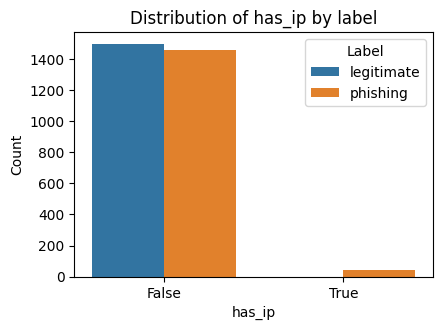

In [25]:
# Create a figure and axes
plt.figure(figsize=(12, 6))

# Iterate through boolean columns and create a subplot for each
for column in phishingScaledDown.select_dtypes(include='bool').columns:
    plt.subplot(2, 3, list(phishingScaledDown.select_dtypes(include='bool').columns).index(column) + 1)  # Using 2, 3 subplot for presentation
    sns.countplot(x=column, hue='label', data=phishingScaledDown)
    plt.title(f'Distribution of {column} by label')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Label')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

I'm having a tough time deciding to keep the booleans in or to remove them. On one hand these attributes do a great job at determining the legitimacy of a URL. In the dataset it seems that both `starts_with_ip` and `has_internal_links`determine that a URL is phishing. On the other hand, if an instance in the dataset returns `True` with `has_punycode`, it is always a legitimate URL. But in all three cases, the amount of `True` values returned is extremely small compared to the total number of instances.

For now, becuase they're such good indicators, I will leave them in. I think that when applied to a large dataset, they could be very useful in predictions. However, if the model is appearing to be too complex, these will likely be the first attributes to go.

In [26]:
# Check attributes for NaN values
phishingScaledDown.isna().sum()

,0
url,0
source,0
label,0
url_length,0
has_ip,0
url_entropy,0
digit_letter_ratio,0
dot_count,0
at_count,0
dash_count,0


Becuase of the missing values, I wanted to check all other attributes for missing values. I found not only was `domain_age_days` missing values but also `whois_data` was too. In the worst case scenario, removing instances where these values are missing would lead to roughly half of the dataset being eliminated, or a third of the data in the best case scenario. Therefore, instead of removing half of the dataset, I'm going to remove these two attributes from analysis.

Perhaps in the larger dataset, removing instances with missing values will be more viable as there are significanly more instances.

In [27]:
# Drop whois_data and domain_age_days
# too many missing attributes
phishingScaledDown = phishingScaledDown.drop(['whois_data', 'domain_age_days'], axis=1)

I still need to check on the other object attributes to see how they will be encoded.

In [28]:
# Check unique values of the remaining object datatypes
phishingScaledDown.select_dtypes(include=['object']).nunique()

,0
url,3000
source,4
label,2


Seeing as there are 3000 instances in the dataset, it makes sense that the `url` attribute has 3000 different values. However, much like a student's name isn't helpful in determining their GPA, a URL won't be helpful in determining if a link is legitimate or malicious.

It might be interesting to include source though so I'll take a close look at that.

In [29]:
# Drop url
# will not help determine legitimacy
phishingScaledDown = phishingScaledDown.drop(['url'], axis=1)

In [30]:
# Investigate source further
phishingScaledDown['source'].value_counts()

,count
source,
Phishing.Database,1395
Majestic,771
Cisco-Umbrella,729
PhishTank,105


Upon further inspection, source might not be a good attribute to include in the model. It would seem likely that all phishing URLs are coming from either Phishing.Database or PhishTank.

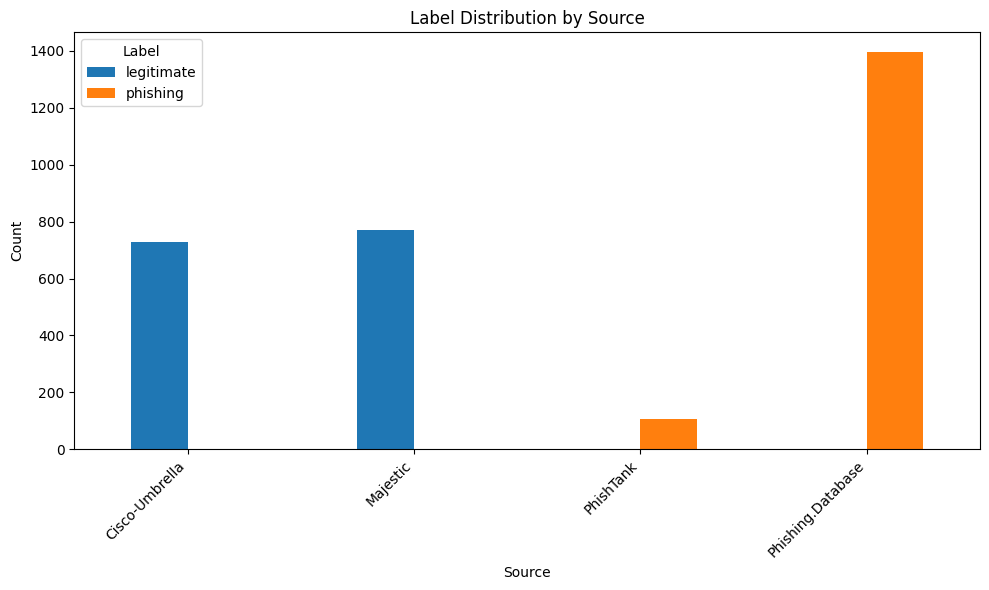

In [31]:
# Group by 'source' and 'label' and count the occurrences
source_label_counts = phishingScaledDown.groupby(['source', 'label'])['label'].count().unstack()

# Create a bar graph
source_label_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Label Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In fact, it is true that all phishing URLs come from either PhishTank or Phishing.Database. Including this data in our model would weaken it as the model would only need to look at this atribute to determine is a URL was legitimate or not. Further, I believe this attribute is to hold where the author of the dataset got the URL from. If that is the case, like `url` it would have no impact on determining legitimacy. Therefore, I'm removing it from consideration in the model.

In [32]:
# Drop source
# will not help determine legitimacy
phishingScaledDown = phishingScaledDown.drop(['source'], axis=1)

After inspecting all of the attributes and determining which ones I will keep, I'm going to binarize `label` so that `legitimate = 0` and `phishing = 1`.

Additionally, I'll turn the already binary boolean variables into integer format so they can be read by the decision tree model

In [33]:
# Binarize label attribute
phishingScaledDown['label'] = phishingScaledDown['label'].map({'legitimate': 0, 'phishing': 1})
phishingScaledDown

,label,url_length,has_ip,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,subdomain_count,nan_char_entropy
0,0,22,False,3.720129,0.200000,3,0,1,2,0.811278
1,0,11,False,3.277613,0.428571,1,0,0,0,0.000000
2,0,13,False,3.180833,0.000000,1,0,0,0,0.000000
3,0,15,False,3.456565,0.000000,1,0,0,0,0.000000
4,0,19,False,3.511085,0.000000,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2995,1,13,False,3.026987,0.000000,1,0,0,0,0.000000
2996,1,112,False,5.113920,0.360000,2,0,4,1,1.846439
2997,1,19,False,3.511085,0.000000,2,0,0,1,0.000000
2998,1,45,False,3.635009,0.000000,1,0,0,0,0.811278


In [34]:
# Binarize all boolean datatypes
# phishingScaledDown['starts_with_ip'] = phishingScaledDown['starts_with_ip'].astype(int)
# phishingScaledDown['has_punycode'] = phishingScaledDown['has_punycode'].astype(int)
# phishingScaledDown['domain_has_digits'] = phishingScaledDown['domain_has_digits'].astype(int)
# phishingScaledDown['has_internal_links'] = phishingScaledDown['has_internal_links'].astype(int)
# phishingScaledDown.dtypes

# Modeling the Data (Decision Tree)

After making all the needed changes to the dataset, I can begin modeling.

Firstly, I split the data into testing and training sets, separating the predictors from `label`. I split the groups into 80% training and 20% testing and used `random_state = 1` for consistent results each time I run the model

In [35]:
# Separate predictors from independent variable
x_df1 = phishingScaledDown.drop(['label'], axis=1)
y_df1 = phishingScaledDown['label']

# Split data into training and testing sets
x_train_df1, x_test_df1, y_train_df1, y_test_df1 = train_test_split(x_df1, y_df1, test_size=0.2, random_state = 42)

In [36]:
x_train_df1

,url_length,has_ip,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,subdomain_count,nan_char_entropy
642,12,False,2.855389,0.000,1,0,0,0,0.000000
700,31,False,3.977917,0.125,3,0,1,2,0.811278
226,12,False,2.751629,0.000,2,0,0,0,0.000000
1697,57,False,4.192821,0.000,1,0,1,0,1.921928
1010,17,False,3.454822,0.000,2,0,1,1,0.918296
...,...,...,...,...,...,...,...,...,...
1638,49,False,4.097594,0.000,5,0,0,1,0.863121
1095,14,False,2.950212,0.000,1,0,0,0,0.000000
1130,13,False,3.238901,0.000,1,0,0,0,0.000000
1294,30,False,3.764735,0.040,3,0,1,2,0.811278


After creating my train and test sets, I begin to fit the training set to the model, make predicitons, and analyze the accuracy of the model

In [37]:
# Create a Decision Tree Classifier and train the model
dt_model = DecisionTreeClassifier(max_depth = 8)
dt_model.fit(x_train_df1, y_train_df1)

# Make predictions on the test set
y_pred_dt1 = dt_model.predict(x_test_df1)

# Evaluate the model
dt_accuracy = accuracy_score(y_test_df1, y_pred_dt1)
dt_report = classification_report(y_test_df1, y_pred_dt1, target_names = ["Legitmate", "Phishing"], output_dict = True)
print("Accuracy :", dt_accuracy)
print(classification_report(y_test_df1, y_pred_dt1, target_names = ["Legitmate", "Phishing"]))

Accuracy : 0.88
              precision    recall  f1-score   support

   Legitmate       0.85      0.94      0.89       313
    Phishing       0.93      0.81      0.87       287

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



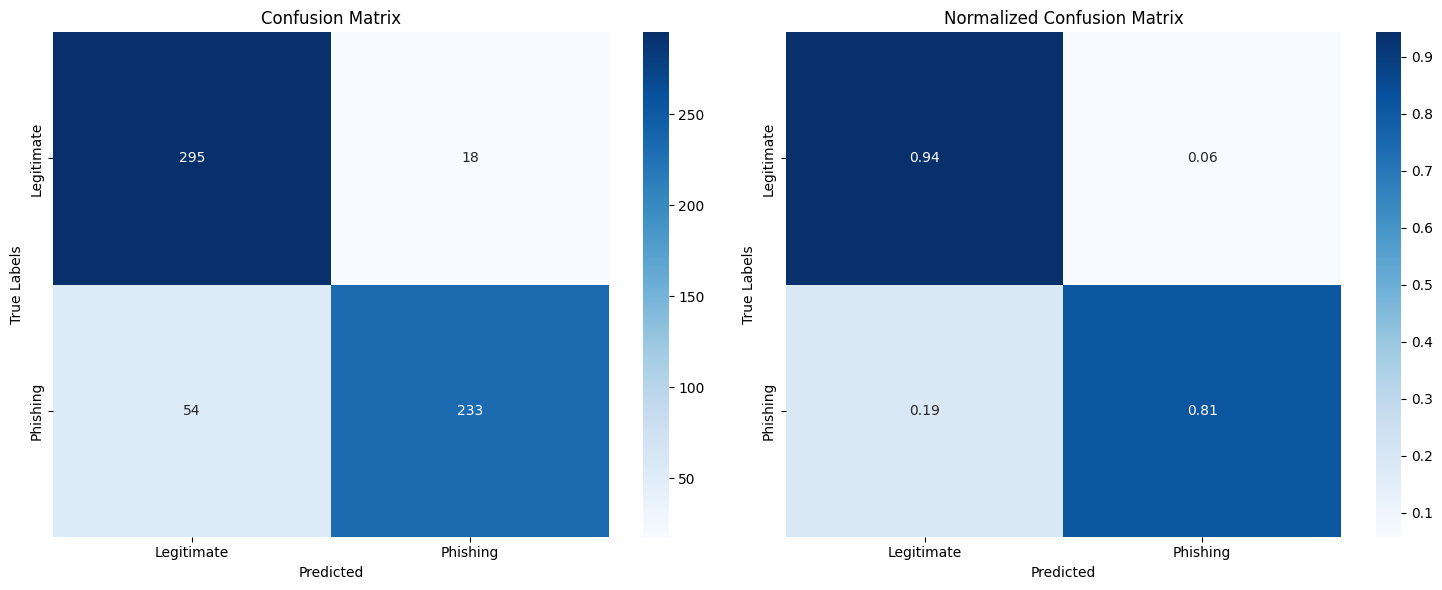

In [38]:
# Create and print the confusion matrix
cm_dt = confusion_matrix(y_test_df1, y_pred_dt1)
cm_dt_normalized = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

# Creating plot for side by side analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
labels = ['Legitimate', 'Phishing']

# Visualizing the Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_dt_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

In [39]:
# Get feature importances from the trained decision tree model
feature_importances = dt_model.feature_importances_

# Create a dictionary to store feature names and their importances
feature_importance_dict = dict(zip(x_train_df1.columns, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Print the feature importance for each feature
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")

nan_char_entropy: 0.6230001976935415
dash_count: 0.16775424525788435
url_entropy: 0.06221235434600777
url_length: 0.06062212751738995
subdomain_count: 0.042355073268056265
digit_letter_ratio: 0.0276350397704955
has_ip: 0.008932495849832337
dot_count: 0.007488466296792353
at_count: 0.0


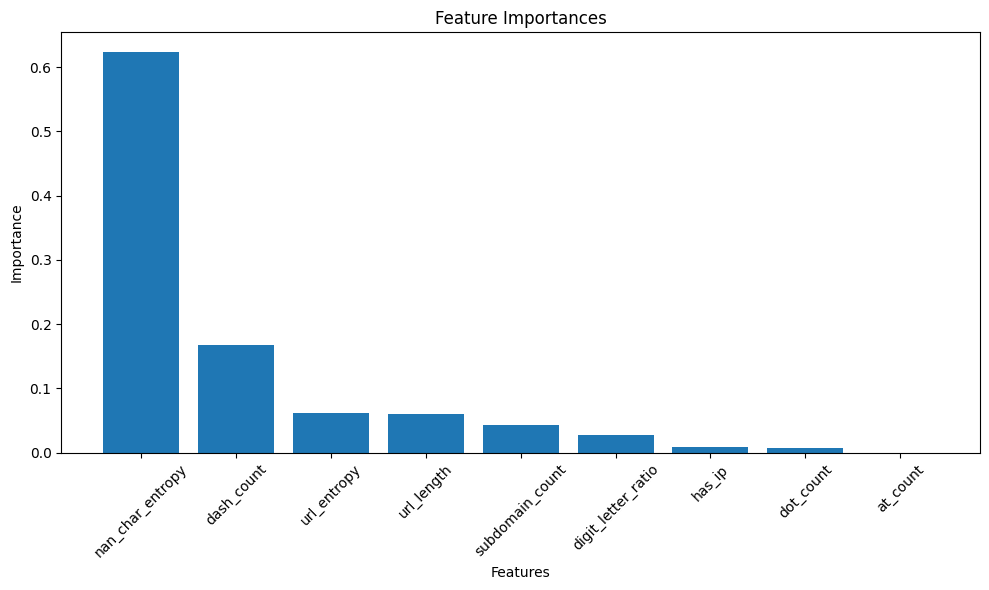

In [40]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_importance.keys(), sorted_feature_importance.values())
plt.xticks(rotation=45)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
#plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [41]:
x_no_nan = x_df1.drop('nan_char_entropy', axis = 1)

In [42]:
# Model without nan_char_entropy
dt_no_nan = DecisionTreeClassifier(max_depth = 8)
dt_no_nan.fit(x_no_nan, y_df1)

# Make predictions
y_pred_dt_no_nan = dt_no_nan.predict(x_no_nan)

# Evaluate the model
dt_no_nan_accuracy = accuracy_score(y_df1, y_pred_dt_no_nan)
print("Accuracy :", dt_no_nan_accuracy)
print(classification_report(y_df1, y_pred_dt_no_nan, target_names = ["Legitmate", "Phishing"]))

Accuracy : 0.8866666666666667
              precision    recall  f1-score   support

   Legitmate       0.84      0.95      0.89      1500
    Phishing       0.94      0.82      0.88      1500

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



# Modeling the Data (Random Forest)

In [43]:
# Create a Random Forest Classifier and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train_df1, y_train_df1)

# Make predictions on the test set
y_pred_rf1 = rf_model.predict(x_test_df1)

# Evaluate the model
rf_accuracy = accuracy_score(y_test_df1, y_pred_rf1)
rf_report = classification_report(y_test_df1, y_pred_rf1, target_names = ["Legitmate", "Phishing"], output_dict = True)

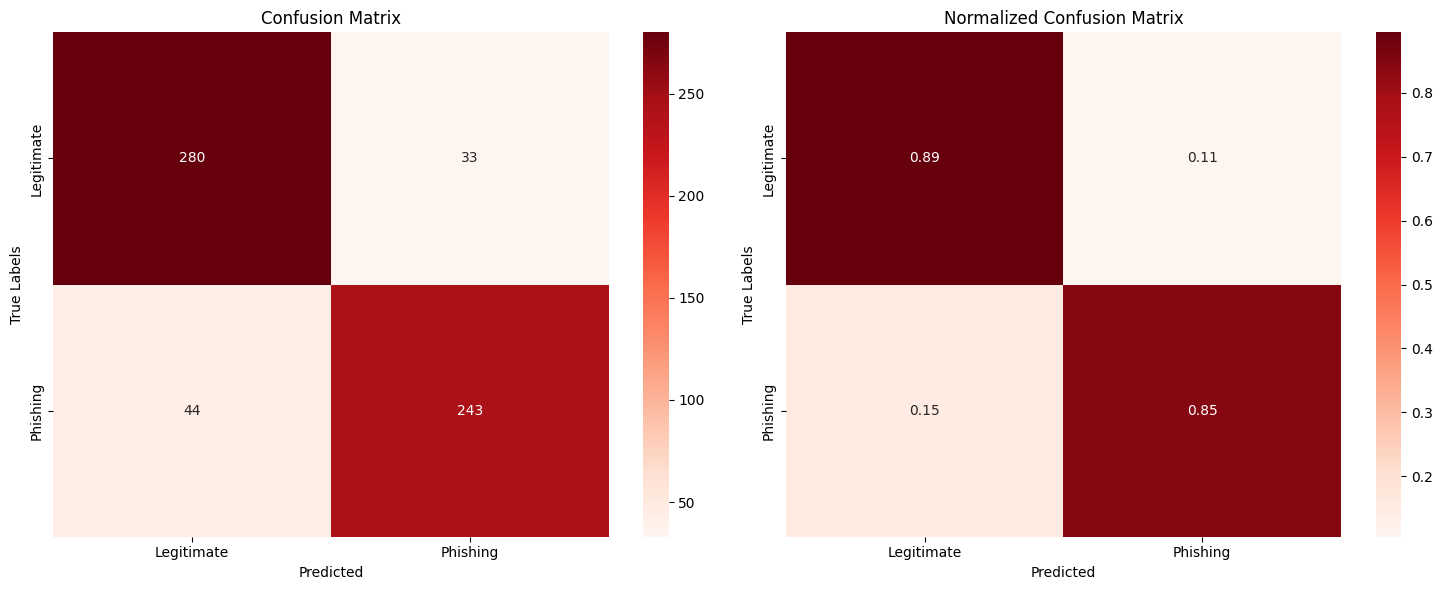

In [44]:
# Create and print the confusion matrix
cm_rf = confusion_matrix(y_test_df1, y_pred_rf1)
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

# Creating plot for side by side analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualizing the Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_rf_normalized, annot=True, fmt=".2f", cmap='Reds', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Modeling the Data (Naive Bayes)

In [45]:
# Create Naive Bayes Model on raw URL data
nb_model = GaussianNB()
nb_model.fit(x_train_df1, y_train_df1)

# Make predictions on the test set
y_pred_nb1 = nb_model.predict(x_test_df1)

# Evaluate the model
nb_accuracy = accuracy_score(y_test_df1, y_pred_nb1)
nb_report = classification_report(y_test_df1, y_pred_nb1, target_names = ["Legitimate", "Phishing"], output_dict = True)
print(classification_report(y_test_df1, y_pred_nb1, target_names = ["Legitimate", "Phishing"]))

              precision    recall  f1-score   support

  Legitimate       0.64      0.97      0.78       313
    Phishing       0.94      0.41      0.57       287

    accuracy                           0.71       600
   macro avg       0.79      0.69      0.68       600
weighted avg       0.78      0.71      0.68       600



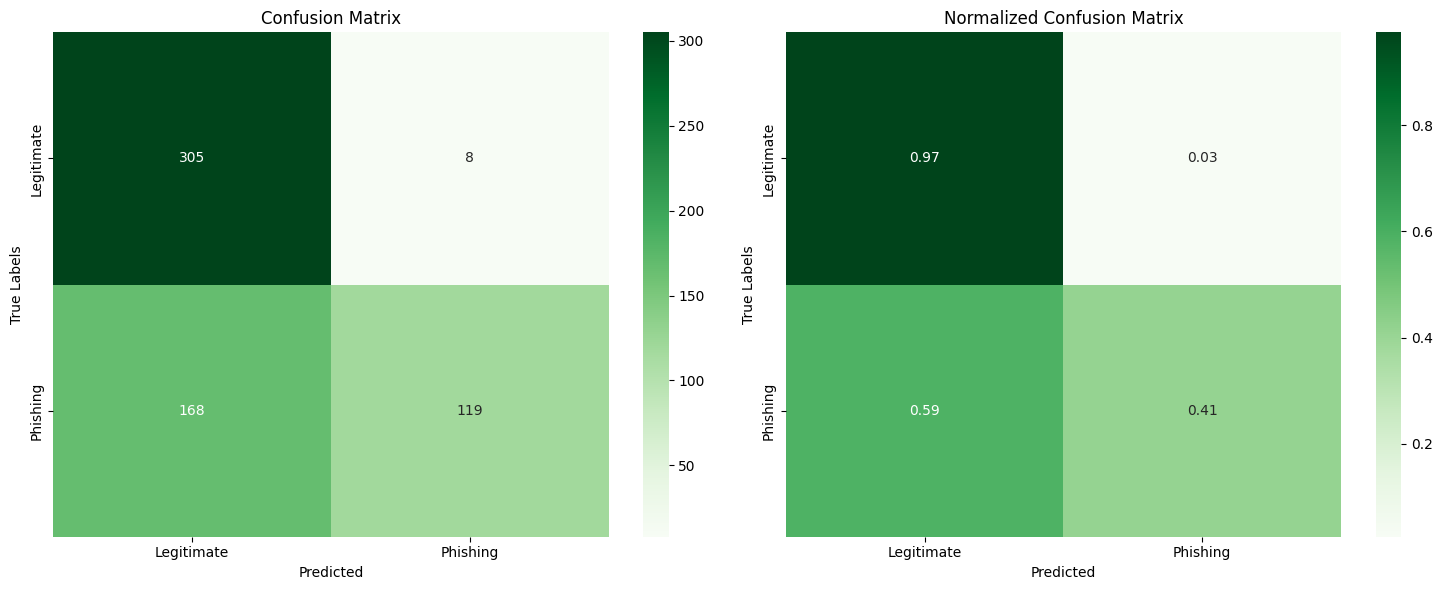

In [46]:
# Create and print the confusion matrix
cm_nb = confusion_matrix(y_test_df1, y_pred_nb1)
cm_nb_normalized = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]

# Creating plot for side by side analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualizing the Confusion Matrix
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_nb_normalized, annot=True, fmt=".2f", cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Comparing the models

In [47]:
# Turn all classification reports into dataframes
dt_report_df = pd.DataFrame(dt_report).transpose()
dt_report_df["Model"] = "Decision Tree"
rf_report_df = pd.DataFrame(rf_report).transpose()
rf_report_df["Model"] = "Random Forest"
nb_report_df = pd.DataFrame(nb_report).transpose()
nb_report_df["Model"] = "Naive Bayes"

# Merge dataframes
all_reports = pd.concat([dt_report_df, rf_report_df, nb_report_df])

# Reset index
all_reports.reset_index(inplace=True)
all_reports.rename(columns={'index': 'Metrics'}, inplace=True)

# Remove rows with "macro avg" or "weighted avg" from all_reports
all_reports = all_reports[~all_reports['Metrics'].isin(['macro avg', 'weighted avg', 'accuracy'])]

# Create a list to store the accuracy values
accuracy_list = [dt_accuracy, rf_accuracy, nb_accuracy]

# Create a new DataFrame with the accuracy metric as a column
accuracy_df = pd.DataFrame({'Model': ['Decision Tree', 'Random Forest', 'Naive Bayes'], 'Accuracy': accuracy_list})

# Print the DataFrame
accuracy_df

# Merge again
all_reports = pd.merge(all_reports, accuracy_df, on='Model')

# Change order of columns
all_reports = all_reports[['Model', 'Metrics', 'Accuracy', 'precision', 'recall', 'f1-score', 'support']]

all_reports

,Model,Metrics,Accuracy,precision,recall,f1-score,support
0,Decision Tree,Legitmate,0.880000,0.845272,0.942492,0.891239,313.0
1,Decision Tree,Phishing,0.880000,0.928287,0.811847,0.866171,287.0
2,Random Forest,Legitmate,0.871667,0.864198,0.894569,0.879121,313.0
3,Random Forest,Phishing,0.871667,0.880435,0.846690,0.863233,287.0
4,Naive Bayes,Legitimate,0.706667,0.644820,0.974441,0.776081,313.0
5,Naive Bayes,Phishing,0.706667,0.937008,0.414634,0.574879,287.0


# Reading in raw URL data

In [48]:
# Read in dataset without any attributes
rawURLs = pd.read_csv("phishing_site_urls.csv")
rawURLs

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


In [49]:
# Change the names of the columns
rawURLs.columns = ['url', 'label']

# Change labels to phishing and legitimate
rawURLs['label'] = rawURLs['label'].map({'good': 0, 'bad': 1})

In [50]:
# Check for repeated values
rawURLs.duplicated().sum()

42150

In [51]:
# Remove any repeated values
rawURLs = rawURLs.drop_duplicates()
rawURLs

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1
...,...,...
516466,23.227.196.215/,1
516467,apple-checker.org/,1
516468,apple-iclods.org/,1
516469,apple-uptoday.org/,1


In [52]:
# URL_length
rawURLs['url_length'] = rawURLs['url'].str.len()

# IP_Address
rawURLs['has_ip'] = rawURLs['url'].apply(has_ip)

# URL Entropy
rawURLs['url_entropy'] = rawURLs['url'].apply(calculate_entropy)

# digit_letter_ratio
rawURLs['digit_letter_ratio'] = rawURLs['url'].apply(calculate_digit_letter_ratio)

# Dot_Count
rawURLs['dot_count'] = rawURLs['url'].str.count('\.')

# At_Count
rawURLs['at_count'] = rawURLs['url'].str.count('@')

# Dash_Count
rawURLs['dash_count'] = rawURLs['url'].str.count('-')

# Subdomain_Count
rawURLs['subdomain_count'] = rawURLs['url'].apply(count_subdomains)

# NaN_Char_Entropy
rawURLs['nan_char_entropy'] = rawURLs['url'].apply(calculate_nan_char_entropy)

rawURLs

<ipython-input-52-6090928684ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawURLs['url_length'] = rawURLs['url'].str.len()
<ipython-input-52-6090928684ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawURLs['has_ip'] = rawURLs['url'].apply(has_ip)
<ipython-input-52-6090928684ee>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,url,label,url_length,has_ip,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,subdomain_count,nan_char_entropy
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,225,False,5.026886,0.429630,6,0,4,0,2.578627
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,81,False,4.686883,0.015385,5,0,2,1,2.332915
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,177,False,4.721044,0.423423,7,0,1,0,1.210810
3,mail.printakid.com/www.online.americanexpress....,1,60,False,4.079842,0.000000,6,0,0,1,0.811278
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,116,False,4.608653,0.256098,1,0,1,0,1.145110
...,...,...,...,...,...,...,...,...,...,...,...
516466,23.227.196.215/,1,15,True,2.923231,0.000000,3,0,0,0,0.811278
516467,apple-checker.org/,1,18,False,3.572431,0.000000,1,0,1,0,1.584963
516468,apple-iclods.org/,1,17,False,3.734522,0.000000,1,0,1,0,1.584963
516469,apple-uptoday.org/,1,18,False,3.683542,0.000000,1,0,1,0,1.584963


# Decision Tree

In [53]:
# Make predictions on the test set
rawURL_pred = dt_model.predict(rawURLs.drop(['url', 'label'], axis = 1))

# Evaluate the model
raw_dt_accuracy = accuracy_score(rawURLs['label'], rawURL_pred)
raw_dt_report = classification_report(rawURLs['label'], rawURL_pred, target_names = ["Legitmate", "Phishing"], output_dict = True)
print("Accuracy:", raw_dt_accuracy)
print(classification_report(rawURLs['label'], rawURL_pred, target_names = ["Legitmate", "Phishing"]))

Accuracy: 0.2284856347447535
              precision    recall  f1-score   support

   Legitmate       0.60      0.01      0.02    392897
    Phishing       0.22      0.97      0.36    114299

    accuracy                           0.23    507196
   macro avg       0.41      0.49      0.19    507196
weighted avg       0.52      0.23      0.10    507196



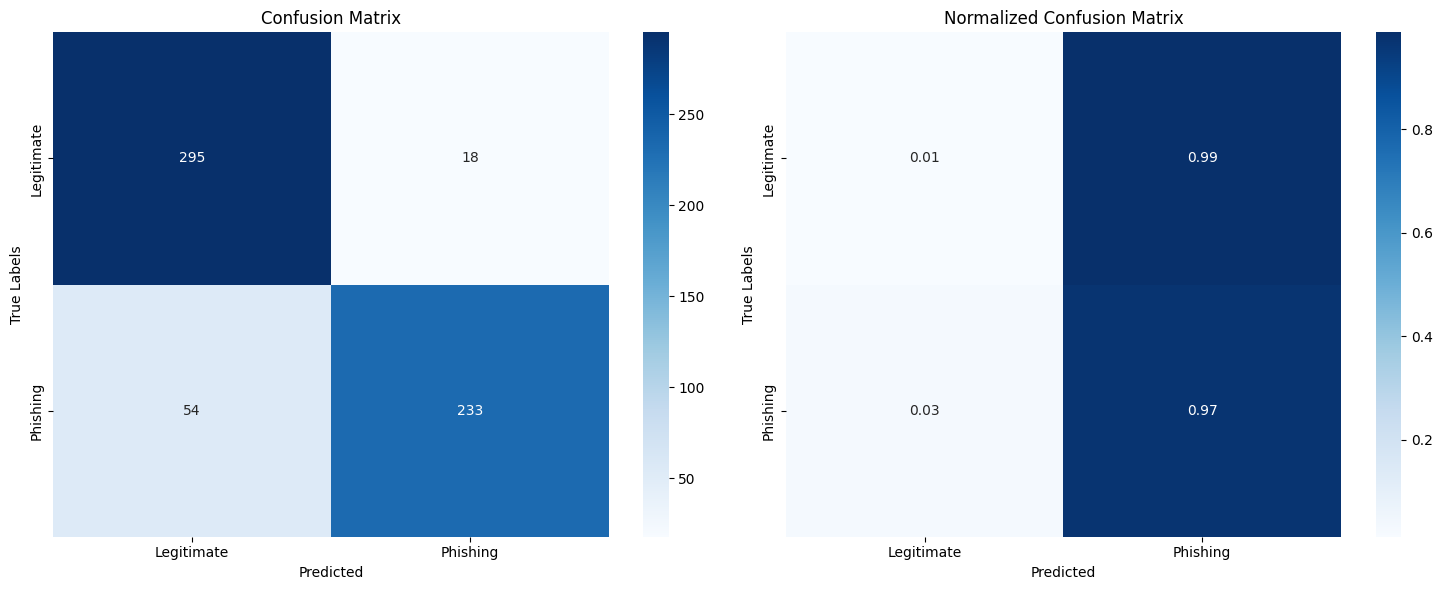

In [54]:
# Create and print the confusion matrix
cm_dt_raw = confusion_matrix(rawURLs['label'], rawURL_pred)
cm_dt_raw_normalized = cm_dt_raw.astype('float') / cm_dt_raw.sum(axis=1)[:, np.newaxis]

# Creating plot for side by side analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
labels = ['Legitimate', 'Phishing']

# Visualizing the Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_dt_raw_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

In [55]:
# Model with no_nan
rawURL_pred_no_nan = dt_no_nan.predict(rawURLs.drop(['url', 'label', 'nan_char_entropy'], axis = 1))

# Evaluate the model
raw_dt_no_nan_accuracy = accuracy_score(rawURLs['label'], rawURL_pred_no_nan)
print("Accuracy :", raw_dt_no_nan_accuracy)

Accuracy : 0.3232833066506834


# Random Forest

In [56]:
# Make predictions on the test set
rawURL_pred_rf = rf_model.predict(rawURLs.drop(['url', 'label'], axis = 1))

# Evaluate the model
raw_rf_accuracy = accuracy_score(rawURLs['label'], rawURL_pred_rf)
raw_rf_report = classification_report(rawURLs['label'], rawURL_pred_rf, target_names = ["Legitmate", "Phishing"], output_dict = True)
print("Accuracy:", raw_rf_accuracy)
print(classification_report(rawURLs['label'], rawURL_pred_rf, target_names = ["Legitimate", "Phishing"]))

Accuracy: 0.22171310499294158
              precision    recall  f1-score   support

  Legitimate       0.07      0.00      0.00    392897
    Phishing       0.22      0.98      0.36    114299

    accuracy                           0.22    507196
   macro avg       0.15      0.49      0.18    507196
weighted avg       0.10      0.22      0.08    507196



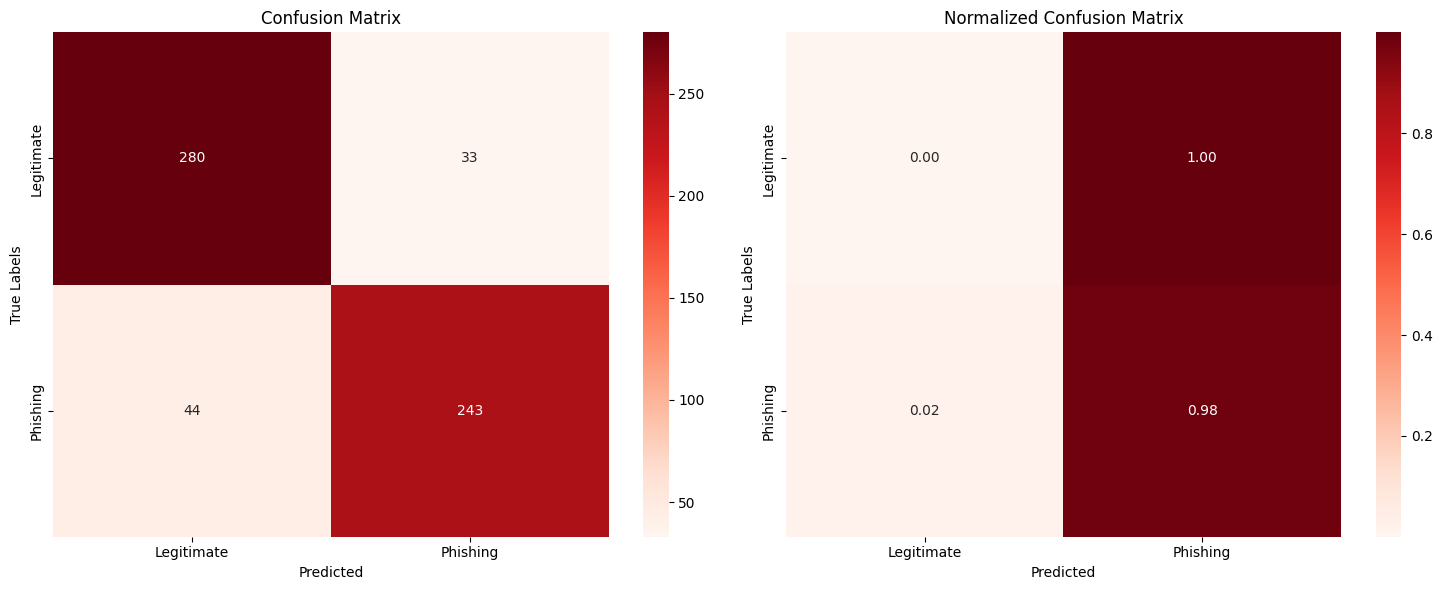

In [57]:
# Create and print the confusion matrix
cm_rf_raw = confusion_matrix(rawURLs['label'], rawURL_pred_rf)
cm_rf_raw_normalized = cm_rf_raw.astype('float') / cm_rf_raw.sum(axis=1)[:, np.newaxis]

# Creating plot for side by side analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualizing the Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_rf_raw_normalized, annot=True, fmt=".2f", cmap='Reds', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Naive Bayes

In [58]:
# Make predictions on the test set
rawURL_pred_nb = nb_model.predict(rawURLs.drop(['url', 'label'], axis = 1))

# Evaluate the model
raw_nb_accuracy = accuracy_score(rawURLs['label'], rawURL_pred_nb)
raw_nb_report = classification_report(rawURLs['label'], rawURL_pred_nb, target_names = ["Legitmate", "Phishing"], output_dict = True)
print("Accuracy:", raw_nb_accuracy)
print(classification_report(rawURLs['label'], rawURL_pred_nb, target_names = ["Legitimate", "Phishing"]))

Accuracy: 0.6139874920149212
              precision    recall  f1-score   support

  Legitimate       0.80      0.66      0.73    392897
    Phishing       0.28      0.44      0.34    114299

    accuracy                           0.61    507196
   macro avg       0.54      0.55      0.53    507196
weighted avg       0.69      0.61      0.64    507196



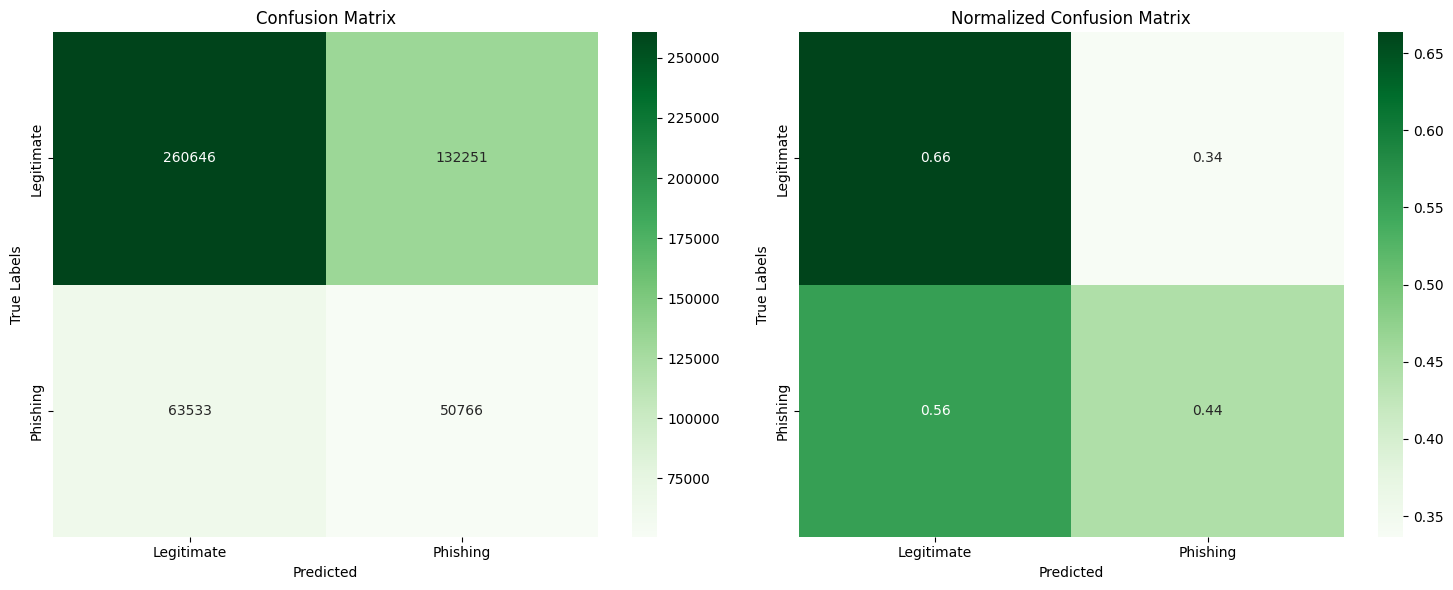

In [59]:
# Create and print the confusion matrix
cm_nb_raw = confusion_matrix(rawURLs['label'], rawURL_pred_nb)
cm_nb_raw_normalized = cm_nb_raw.astype('float') / cm_nb_raw.sum(axis=1)[:, np.newaxis]

# Creating plot for side by side analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Visualizing the Confusion Matrix
sns.heatmap(cm_nb_raw, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_nb_raw_normalized, annot=True, fmt=".2f", cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Comparing the Models

In [60]:
# Turn all classification reports into dataframes
raw_dt_report_df = pd.DataFrame(raw_dt_report).transpose()
raw_dt_report_df["Model"] = "Decision Tree"
raw_rf_report_df = pd.DataFrame(raw_rf_report).transpose()
raw_rf_report_df["Model"] = "Random Forest"
raw_nb_report_df = pd.DataFrame(raw_nb_report).transpose()
raw_nb_report_df["Model"] = "Naive Bayes"

# Merge dataframes
all_raw_reports = pd.concat([raw_dt_report_df, raw_rf_report_df, raw_nb_report_df])

# Reset index
all_raw_reports.reset_index(inplace=True)
all_raw_reports.rename(columns={'index': 'Metrics'}, inplace=True)

# Remove rows with "macro avg" or "weighted avg" from all_reports
all_raw_reports = all_raw_reports[~all_raw_reports['Metrics'].isin(['macro avg', 'weighted avg', 'accuracy'])]

# Create a list to store the accuracy values
raw_accuracy_list = [raw_dt_accuracy, raw_rf_accuracy, raw_nb_accuracy]

# Create a new DataFrame with the accuracy metric as a column
raw_accuracy_df = pd.DataFrame({'Model': ['Decision Tree', 'Random Forest', 'Naive Bayes'], 'Accuracy': raw_accuracy_list})

# Merge again
all_raw_reports = pd.merge(all_raw_reports, raw_accuracy_df, on='Model')

# Change order of columns
all_raw_reports = all_raw_reports[['Model', 'Metrics', 'Accuracy', 'precision', 'recall', 'f1-score', 'support']]

all_raw_reports

,Model,Metrics,Accuracy,precision,recall,f1-score,support
0,Decision Tree,Legitmate,0.228486,0.600405,0.012085,0.023692,392897.0
1,Decision Tree,Phishing,0.228486,0.222595,0.972353,0.362260,114299.0
2,Random Forest,Legitmate,0.221713,0.069464,0.000379,0.000754,392897.0
3,Random Forest,Phishing,0.221713,0.222360,0.982537,0.362648,114299.0
4,Naive Bayes,Legitmate,0.613987,0.804019,0.663395,0.726969,392897.0
5,Naive Bayes,Phishing,0.613987,0.277384,0.444151,0.341495,114299.0


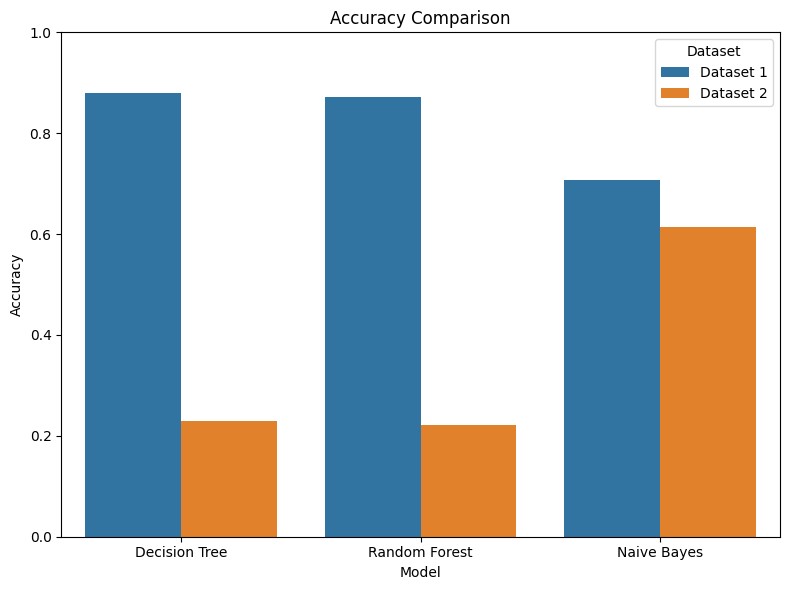

In [61]:
# Create a DataFrame for plotting
accuracyComparisons = pd.DataFrame({'Model': ['Decision Tree', 'Random Forest', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'Naive Bayes']})

accuracyComparisons['Accuracy'] = [dt_accuracy, rf_accuracy, nb_accuracy, raw_dt_accuracy, raw_rf_accuracy, raw_nb_accuracy]
accuracyComparisons['Dataset'] = ['Dataset 1', 'Dataset 1', 'Dataset 1', 'Dataset 2', 'Dataset 2', 'Dataset 2']

accuracyComparisons

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=accuracyComparisons)
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

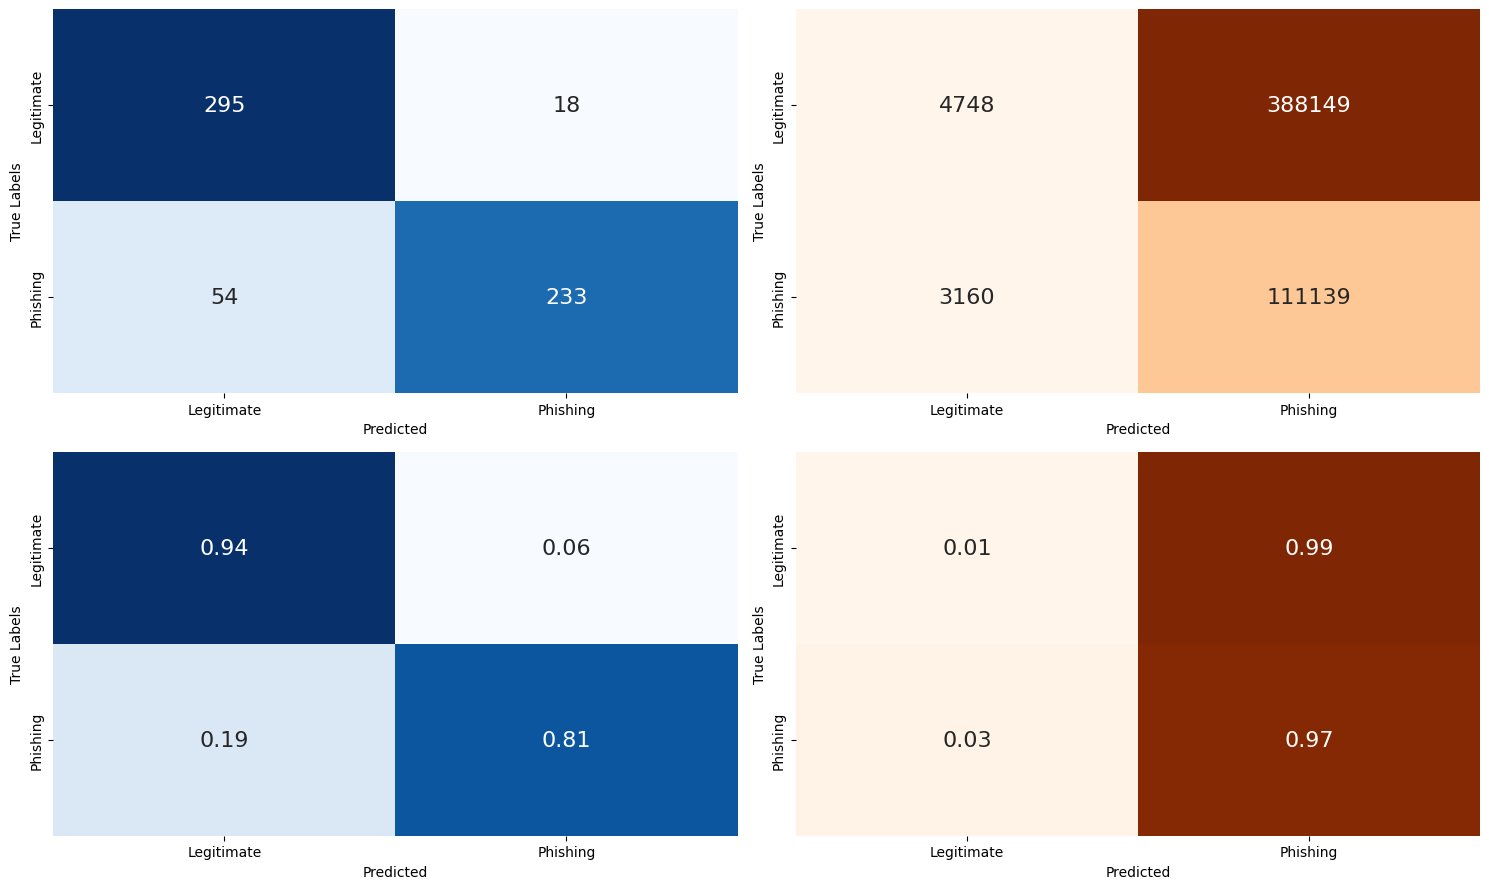

In [62]:
# Creating plot for side by side analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
labels = ['Legitimate', 'Phishing']

# Visualizing the Confusion Matrix
sns.heatmap(cm_dt, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0,0], cbar=False)
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('True Labels')

# Visualizing the Confusion Matrix
sns.heatmap(cm_dt_raw, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[0,1], cbar=False)
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('True Labels')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_dt_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1,0], cbar=False)
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('True Labels')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_dt_raw_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[1,1], cbar=False)
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

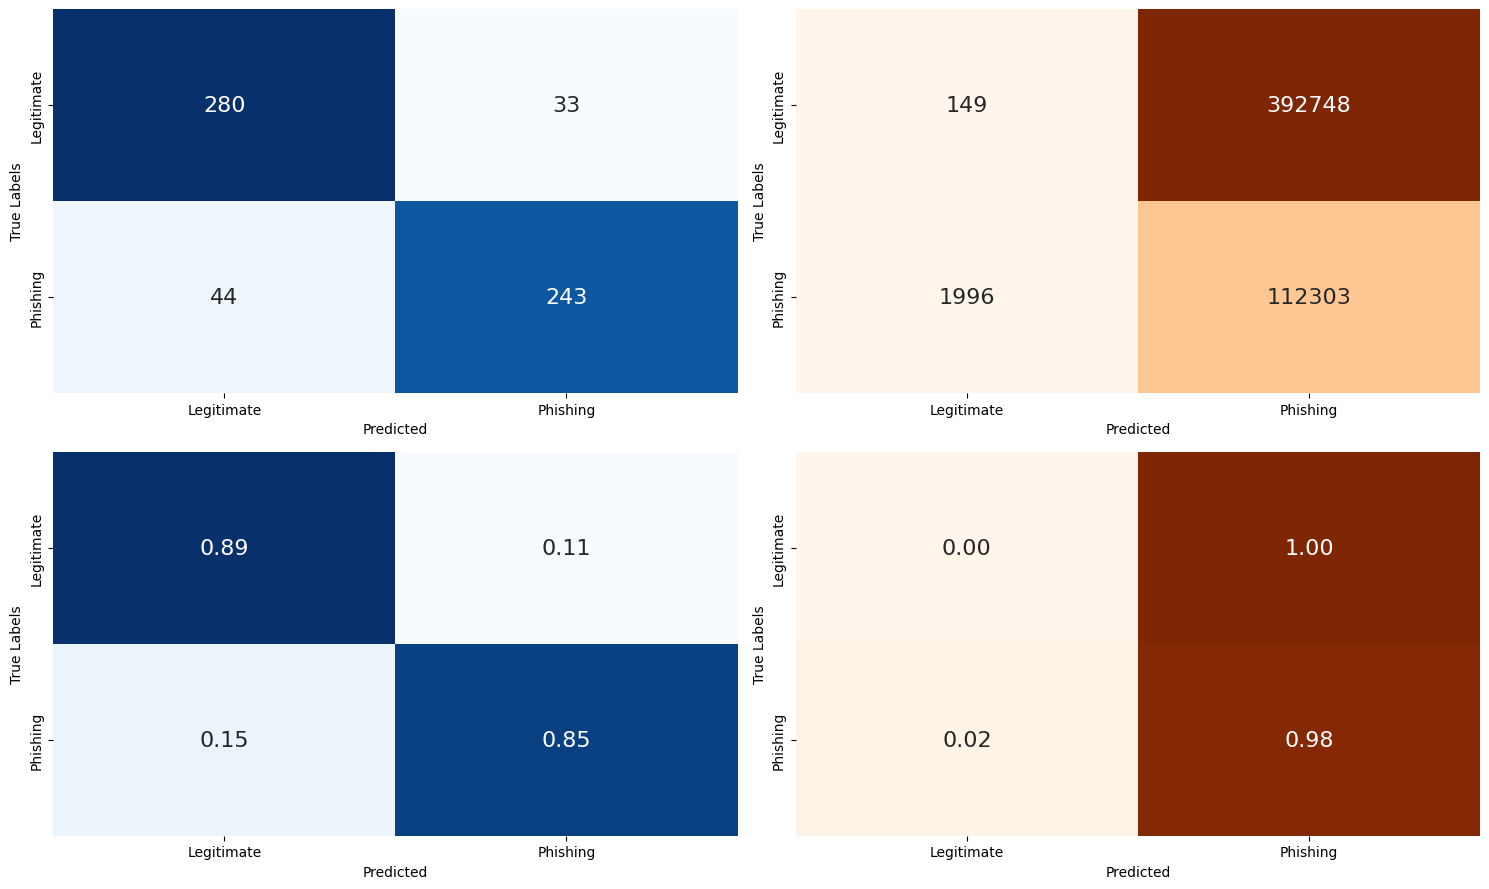

In [63]:
# Creating plot for side by side analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
labels = ['Legitimate', 'Phishing']

# Visualizing the Confusion Matrix
sns.heatmap(cm_rf, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0,0], cbar=False)
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('True Labels')

# Visualizing the Confusion Matrix
sns.heatmap(cm_rf_raw, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[0,1], cbar=False)
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('True Labels')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_rf_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1,0], cbar=False)
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('True Labels')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_rf_raw_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[1,1], cbar=False)
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

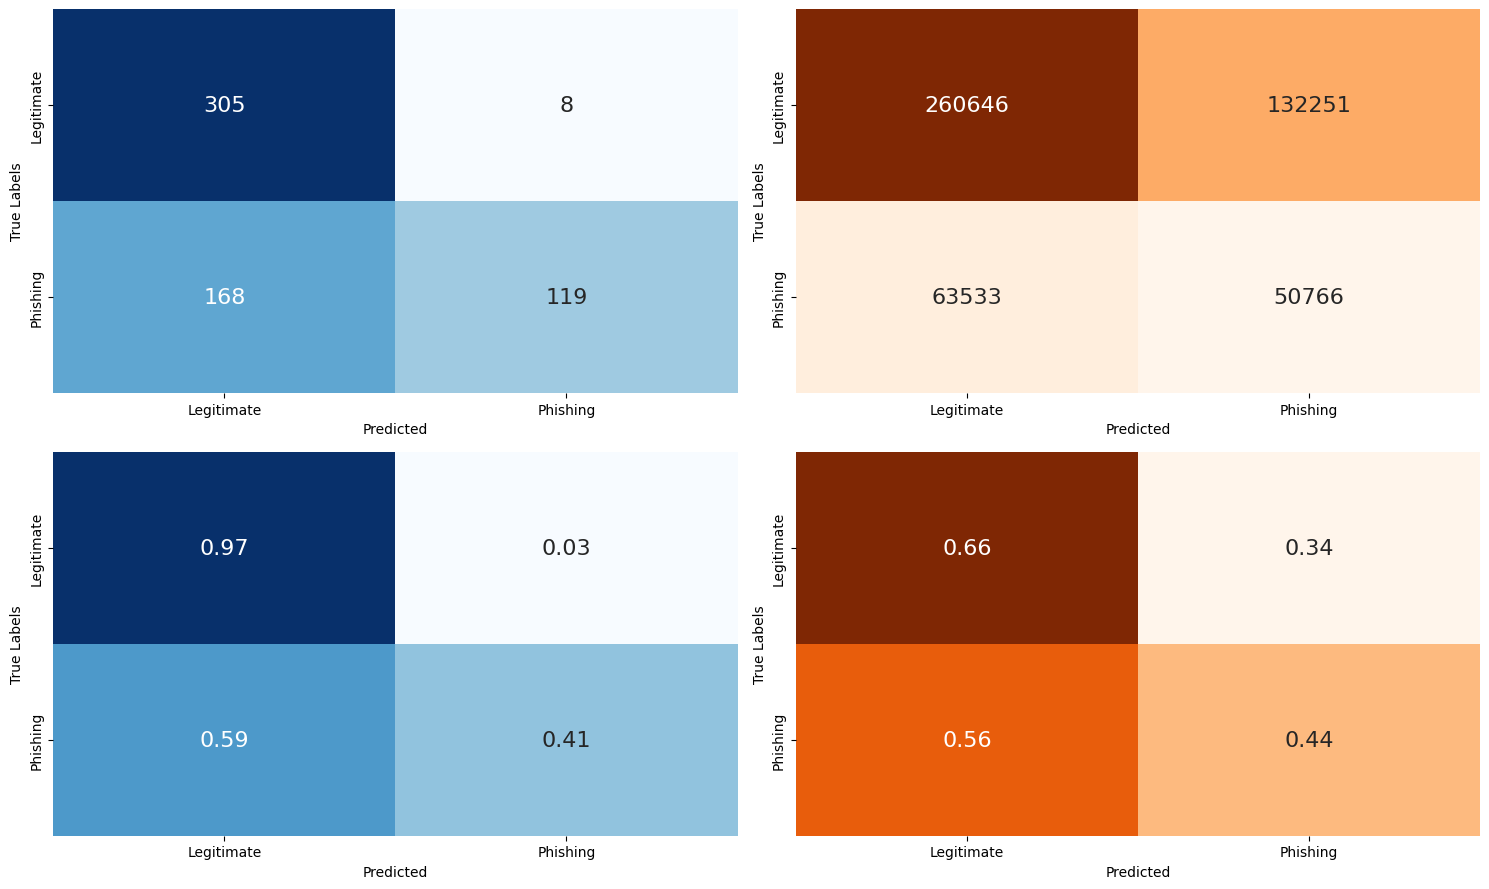

In [64]:
# Creating plot for side by side analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
labels = ['Legitimate', 'Phishing']

# Visualizing the Confusion Matrix
sns.heatmap(cm_nb, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0,0], cbar=False)
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('True Labels')

# Visualizing the Confusion Matrix
sns.heatmap(cm_nb_raw, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[0,1], cbar=False)
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('True Labels')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_nb_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1,0], cbar=False)
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('True Labels')

# Visualize the Normalized Confusion Matrix
sns.heatmap(cm_nb_raw_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[1,1], cbar=False)
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()